# LA Metro Bikeshare EDA
1. Story planning
2. Obtain data sets - D
3. Obtain lat longs with scraper
4. Clean data sets 
5. Feature engineering
6. Visualization
7. TBD

Is there a predictive value that can be derived for kinds of locations
    1. Finding lat long coordinates of schools or public services and mapping out color coded heat maps based on the type of establishment
    2. Finding out where most bike stations are likely to be located
    3. Goal is to find out where you would set up more bike locations + figure out why particular locations are popular and predict accordingly

In [319]:
# importing necessary packages
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import pprint
import missingno as msno
from urllib.request import Request, urlopen
import json
from bs4 import BeautifulSoup
import requests
import re
import numpy as np

# Core rides dataset

In [320]:
# there are 4 files for the data for each quarter from 2017 Q3 to 2018 Q2
_2017Q3 = pd.read_csv('../data/external/2017Q3.csv')
_2017Q4 = pd.read_csv('../data/external/2017Q4.csv')
_2018Q1 = pd.read_csv('../data/external/2018Q1.csv')
_2018Q2 = pd.read_csv('../data/external/2018Q2.csv')

In [321]:
# concatenate the four quarters of ride sharing data into a year's worth
rides_df = pd.concat([_2017Q3,_2017Q4,_2018Q1,_2018Q2])
rides_df.shape

(286295, 14)

In [322]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,33404951,36,7/1/2017 0:09,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up
1,33404950,13,7/1/2017 0:10,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up
2,33404947,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up
3,33404948,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up
4,33404949,12,7/1/2017 0:11,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up


In [323]:
rides_df.describe()

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration
count,2.862950e+05,286295.000000,286295.00000,285660.000000,285660.000000,286295.000000,281900.000000,281900.000000,286295.000000,286295.000000
mean,6.480957e+07,35.034206,3420.79971,34.045820,-118.271421,3414.716265,34.045689,-118.271667,7900.573014,30.907910
std,1.808223e+07,115.722913,538.47854,0.065529,0.097562,537.212309,0.065038,0.098157,2717.473129,66.243336
min,3.340494e+07,1.000000,3000.00000,33.710979,-118.491341,3000.000000,33.710979,-118.491341,4727.000000,0.000000
25%,4.905606e+07,7.000000,3031.00000,34.039982,-118.262733,3031.000000,34.039982,-118.262733,6053.000000,0.000000
50%,6.534754e+07,12.000000,3064.00000,34.046822,-118.252441,3063.000000,34.046810,-118.252830,6403.000000,30.000000
75%,8.085881e+07,25.000000,4156.00000,34.053200,-118.237411,4156.000000,34.051941,-118.237410,12019.000000,30.000000
max,9.508575e+07,1440.000000,4254.00000,34.165291,-118.116530,4254.000000,34.165291,-118.116530,12456.000000,365.000000


In [324]:
rides_df.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_station            int64
start_lat              float64
start_lon              float64
end_station              int64
end_lat                float64
end_lon                float64
bike_id                  int64
plan_duration            int64
trip_route_category     object
passholder_type         object
dtype: object

On first glance, all time variables like start_time and end_time should be converted to a date time object.

In [325]:
# converting start and end times to datetime objects

rides_df['start_time'] = pd.to_datetime(rides_df['start_time'])
rides_df['end_time'] = pd.to_datetime(rides_df['end_time'])

In [326]:
# checking to see if columns were indeed converted
rides_df.dtypes

trip_id                         int64
duration                        int64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_station                   int64
start_lat                     float64
start_lon                     float64
end_station                     int64
end_lat                       float64
end_lon                       float64
bike_id                         int64
plan_duration                   int64
trip_route_category            object
passholder_type                object
dtype: object

In [327]:
# quick look at which station is the most commonly used and where it is (Venice beach)
rides_df['start_station'].mode()

0    4214
dtype: int64

In [328]:
rides_df[rides_df['start_station'] == 4214].head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
51390,44620579,16,2017-09-07 10:40:00,2017-09-07 10:56:00,4214,33.99556,-118.481552,4216,34.023392,-118.479637,11200,30,One Way,Monthly Pass
51391,44627346,28,2017-09-07 10:40:00,2017-09-07 11:08:00,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12416,365,One Way,Flex Pass
51392,44641141,196,2017-09-07 10:40:00,2017-09-07 13:56:00,4214,33.99556,-118.481552,3000,NaN,NaN,12011,30,One Way,Monthly Pass
51393,44641142,167,2017-09-07 10:40:00,2017-09-07 13:27:00,4214,33.99556,-118.481552,4212,33.988129,-118.471741,12241,365,One Way,Flex Pass
51394,44620577,17,2017-09-07 10:41:00,2017-09-07 10:58:00,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12356,30,One Way,Monthly Pass


Here we use the missingno package to check for NA values in the dataframe. As the number of missing values seem almost negligible compared to the total number of observations, we drop the rows. Around 4849 rows, or 1.7% of total rows were dropped.

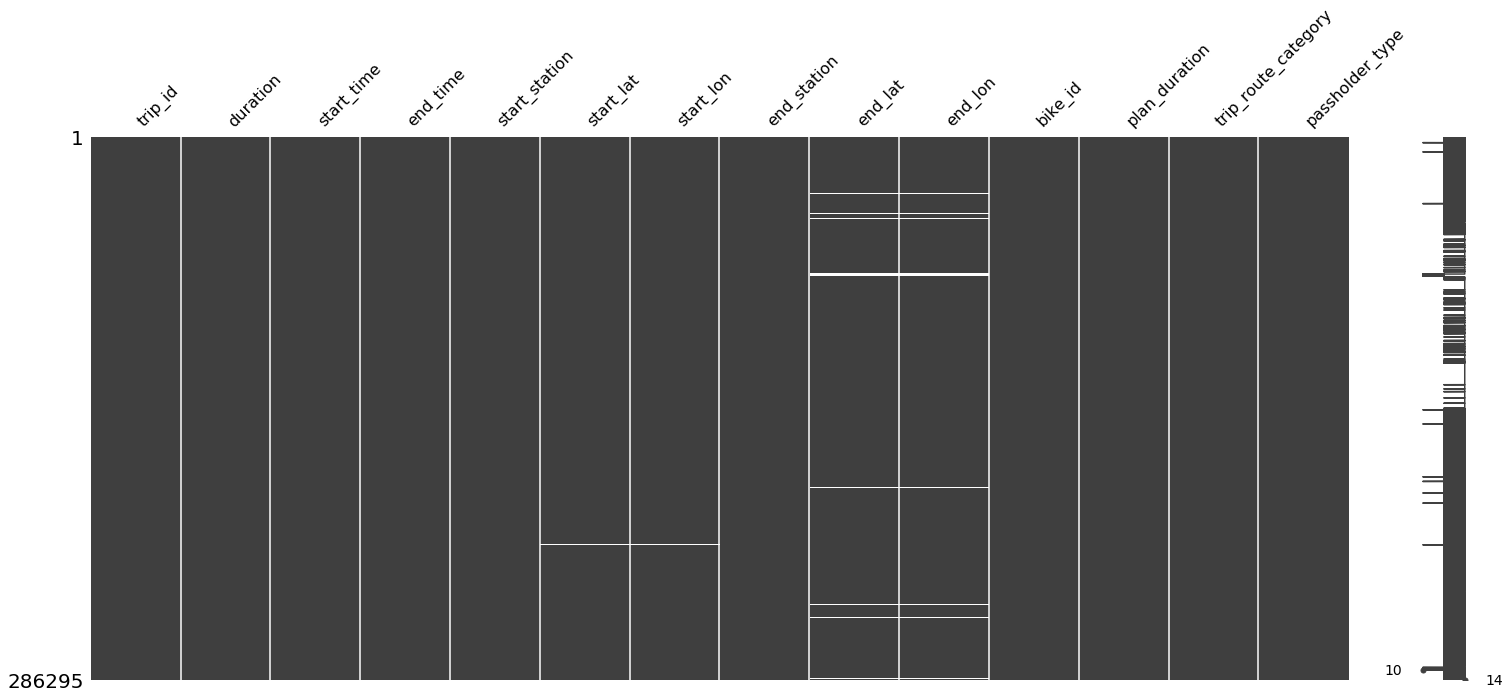

In [329]:
# check for missing values
%matplotlib inline
msno.matrix(rides_df)

In [330]:
# dropping rows with na values
rides_df = rides_df.dropna()
rides_df.shape

(281446, 14)

# External datasets of geolocations

In order to obtain a perspective of where most rides occur and landmarks around LA, we utilize multiple data sources and APIs to obtain the relevant latitude and longitude values.

### Bike station locations
We first start off with more detailed information on the bike stations. To do this, we download the json file from https://bikeshare.metro.net/stations/json/ which includes addresses and capacities of different bike stations.

In [331]:
# read in the json file with station information
with open ('../data/external/bike_stations.json') as f:
    station_data = json.load(f)

In [332]:
# extract useful columns from the jason and append it to a list
all_station_info = []
for station in station_data['features']: 
    station_attr = []
    station_attr.append([station['properties']['kioskId'], station['properties']['addressStreet'], 
                         station['properties']['addressZipCode'], station['properties']['name'],
                         station['properties']['totalDocks']])
    all_station_info.append(station_attr[0])

In [333]:
# check to see if each element in list is a list of station attributes we need
all_station_info[2]

[3007, '557 S 5th Street', '90071', '5th & Grand', 23]

In [334]:
# create new dataframe based on the attributes
stations_info = pd.DataFrame(all_station_info, columns=['kiosk_id','address_street','address_zip','station_name','total_docks'])
stations_info.head()

,kiosk_id,address_street,address_zip,station_name,total_docks
0,3005,723 Flower Street,90017,7th & Flower,27
1,3006,729 S Olive Street,90014,Olive & 8th,24
2,3007,557 S 5th Street,90071,5th & Grand,23
3,3008,865 S Figueroa Street,90017,Figueroa & 9th,15
4,3010,401 East 11th Street,90015,11th & Maple,22


In [335]:
# adding start station attributes
rides_df = pd.merge(rides_df, stations_info, how = "left", left_on = 'start_station', 
               right_on = ['kiosk_id']).rename(columns = {'address_street':'start_address',
                                                          'address_zip':'start_zip','station_name':'start_name',
                                                          'total_docks':'start_docks'}).drop('kiosk_id',1)
# adding end station attributes
rides_df = pd.merge(rides_df, stations_info, how = "left", left_on = 'end_station', 
               right_on = ['kiosk_id']).rename(columns = {'address_street':'end_address',
                                                          'address_zip':'end_zip','station_name':'end_name',
                                                          'total_docks':'end_docks'}).drop('kiosk_id',1)

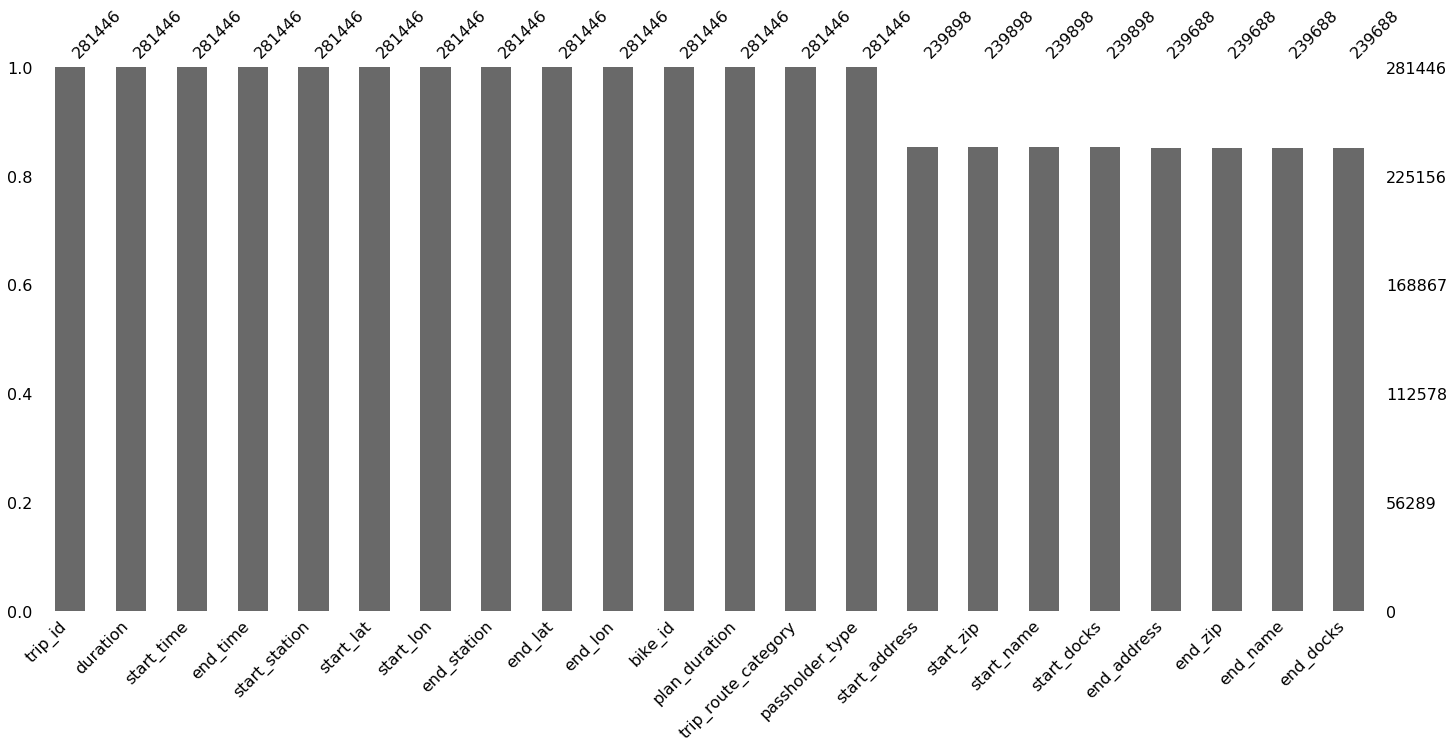

In [336]:
# checking for missing address details
msno.bar(rides_df)

There seems to be about 20% of entries with missing station information. As this is a sizeable portion of the dataset, we can take a closer look to see how to deal with these missing values.

In [429]:
rides_df['start_station'].value_counts().describe()

count      124.000000
mean      2269.725806
std       2154.035881
min          6.000000
25%        804.500000
50%       1544.500000
75%       3019.500000
max      11437.000000
Name: start_station, dtype: float64

In [430]:
rides_df['start_docks'].describe()

count    239898.000000
mean         22.869882
std           5.119422
min          13.000000
25%          19.000000
50%          22.000000
75%          27.000000
max          36.000000
Name: start_docks, dtype: float64

In [440]:
median_mask = rides_df[rides_df.isnull().any(axis = 1)]['start_station'].value_counts() > rides_df['start_station'].value_counts().median()
locations_to_fill = rides_df[rides_df.isnull().any(axis = 1)]['start_station'].value_counts()[median_mask]
locations_to_fill.keys()

Int64Index([4162, 4153, 4181, 4165, 4176, 4142, 4157, 4180, 4163, 4159, 4177], dtype='int64')

In [441]:
str(round(locations_to_fill.sum()/rides_df[rides_df.isnull().any(axis = 1)]['start_station'].value_counts().sum(),2)*100) + '%'

'47.0%'

In [442]:
lats = []
longs = []
for station_id in locations_to_fill.keys():
    lats.append(rides_df['start_lat'][rides_df['start_station'] == station_id].iloc[0])
    longs.append(rides_df['start_lon'][rides_df['start_station'] == station_id].iloc[0])

In [451]:
manual_add_cols = list(stations_info.columns)
manual_add_cols.extend(('start_lat','start_lon'))
manual_add_cols[0] = 'start_station'
manual_kiosk_add = pd.DataFrame(columns = manual_add_cols)
manual_kiosk_add['start_station'] = np.asarray(locations_to_fill.keys())
manual_kiosk_add['end_station'] = manual_kiosk_add['start_station']
manual_kiosk_add['start_lat'] = np.asarray(lats)
manual_kiosk_add['start_lon'] = np.asarray(longs)
manual_kiosk_add

,start_station,address_street,address_zip,station_name,total_docks,start_lat,start_lon,end_station
0,4162,NaN,NaN,NaN,NaN,34.147499,-118.148010,4162
1,4153,NaN,NaN,NaN,NaN,34.156181,-118.166687,4153
2,4181,NaN,NaN,NaN,NaN,34.146221,-118.135262,4181
3,4165,NaN,NaN,NaN,NaN,34.141750,-118.149063,4165
4,4176,NaN,NaN,NaN,NaN,34.137859,-118.122414,4176
5,4142,NaN,NaN,NaN,NaN,34.144588,-118.144592,4142
6,4157,NaN,NaN,NaN,NaN,34.140999,-118.132088,4157
7,4180,NaN,NaN,NaN,NaN,34.137951,-118.128502,4180
8,4163,NaN,NaN,NaN,NaN,34.150471,-118.132019,4163
9,4159,NaN,NaN,NaN,NaN,34.145901,-118.116539,4159


In [452]:
manual_street_addresses = []
manual_zips = []
manual_names = []
manual_street_addresses.extend(('136 E Holly St','1001 Rose Bowl Dr','2-26 N Oak Knoll Ave','272-260 S Raymond Ave', '1320-1342 San Pasqual St', '300 E Green St', '270 S Lake Ave', '1085-1041 San Pasqual St', '300 N Lake Ave','1570 E Colorado Blvd','50 S Madison Ave'))
manual_zips.extend((91103, 91103, 91101, 91105, 91106, 91101, 91101, 91106, 91101, 91106, 91101))
manual_names.extend(('Memorial Park Station', 'Rose Bowl Stadium', 'E Colorado Blvd Target','Central Park','Caltech Student Services','Pasadena Civic Auditorium', 'The Shops on Lake Avenue','Caltech Graduate Housing', 'Gateway Plaza', 'Pasadena City College Shatford Library', 'Playhouse parking lot'))

In [453]:
manual_kiosk_add['address_street'] = np.asarray(manual_street_addresses)
manual_kiosk_add['address_zip'] = np.asarray(manual_zips)
manual_kiosk_add['station_name'] = np.asarray(manual_names)
manual_kiosk_add = manual_kiosk_add.fillna(22)

# start_manual_add = manual_kiosk_add
# start_manual_add.columns = ['start_station','start_address','start_zip','start_name', 'start_docks','start_lat','start_lon']
# test = pd.merge(rides_df, start_manual_add, how = 'outer', on = ['start_station','start_lat','start_lon'])

# end_manual_add = manual_kiosk_add
# end_manual_add.columns = ['end_station','end_address','end_zip','end_name', 'end_docks','end_lat','end_lon']
# test = pd.merge(test, end_manual_add, how = 'outer', on = ['end_station','end_lat','end_lon'])

manual_kiosk_add

,start_station,address_street,address_zip,station_name,total_docks,start_lat,start_lon,end_station
0,4162,136 E Holly St,91103,Memorial Park Station,22,34.147499,-118.148010,4162
1,4153,1001 Rose Bowl Dr,91103,Rose Bowl Stadium,22,34.156181,-118.166687,4153
2,4181,2-26 N Oak Knoll Ave,91101,E Colorado Blvd Target,22,34.146221,-118.135262,4181
3,4165,272-260 S Raymond Ave,91105,Central Park,22,34.141750,-118.149063,4165
4,4176,1320-1342 San Pasqual St,91106,Caltech Student Services,22,34.137859,-118.122414,4176
5,4142,300 E Green St,91101,Pasadena Civic Auditorium,22,34.144588,-118.144592,4142
6,4157,270 S Lake Ave,91101,The Shops on Lake Avenue,22,34.140999,-118.132088,4157
7,4180,1085-1041 San Pasqual St,91106,Caltech Graduate Housing,22,34.137951,-118.128502,4180
8,4163,300 N Lake Ave,91101,Gateway Plaza,22,34.150471,-118.132019,4163
9,4159,1570 E Colorado Blvd,91106,Pasadena City College Shatford Library,22,34.145901,-118.116539,4159


In [468]:
# function to use the df.where function to map values to original dataframe
def fill_df_null(df1, df2, target_col, common_col, alt_name):
    df1[target_col] = df1[target_col].where(df1[target_col].notnull(), 
                                           df1[common_col].map(df2.set_index(common_col)[alt_name]))

fill_df_null(rides_df, manual_kiosk_add, 'start_address', 'start_station', 'address_street')
fill_df_null(rides_df, manual_kiosk_add, 'start_zip', 'start_station', 'address_zip')
fill_df_null(rides_df, manual_kiosk_add, 'start_name', 'start_station', 'station_name')
fill_df_null(rides_df, manual_kiosk_add, 'start_docks', 'start_station', 'total_docks')

fill_df_null(rides_df, manual_kiosk_add, 'end_address', 'end_station', 'address_street')
fill_df_null(rides_df, manual_kiosk_add, 'end_zip', 'end_station', 'address_zip')
fill_df_null(rides_df, manual_kiosk_add, 'end_name', 'end_station', 'station_name')
fill_df_null(rides_df, manual_kiosk_add, 'end_docks', 'end_station', 'total_docks')

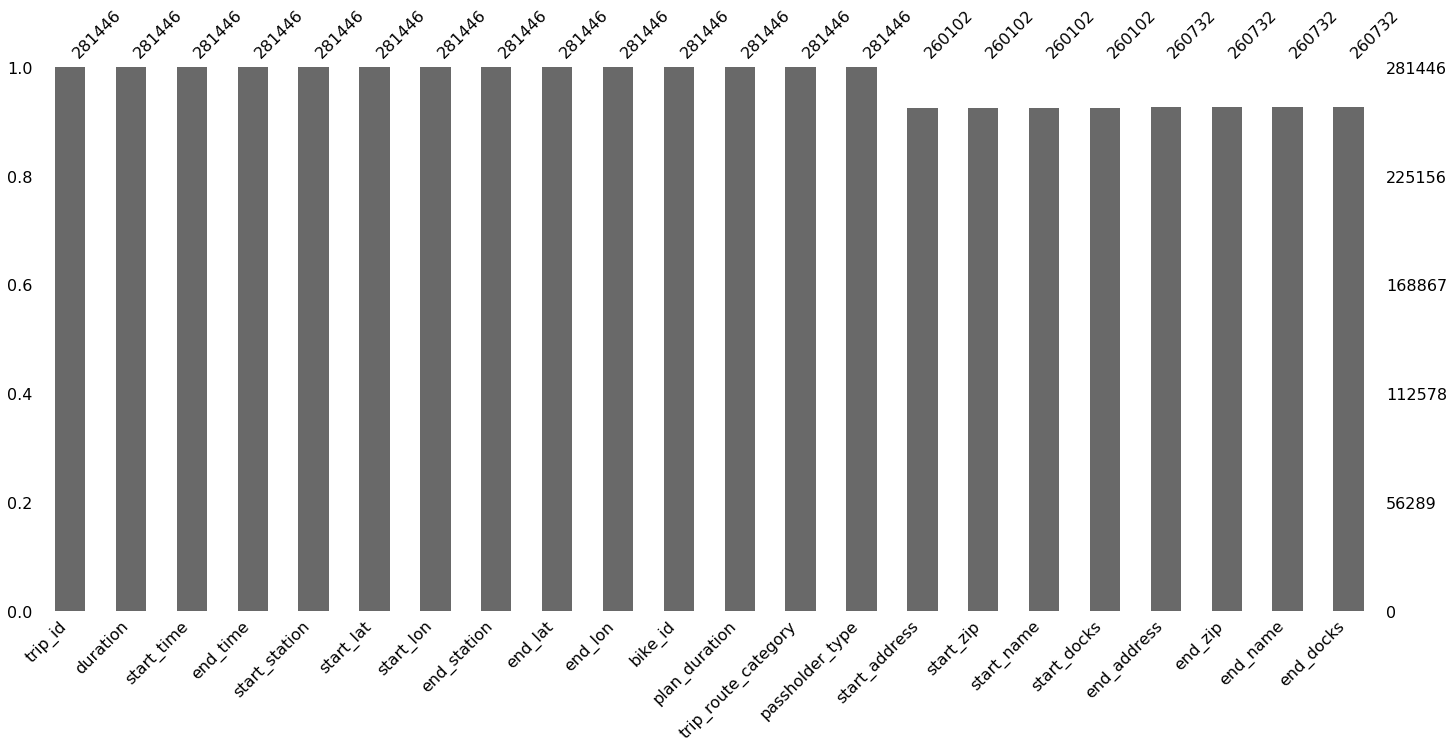

In [469]:
msno.bar(rides_df)

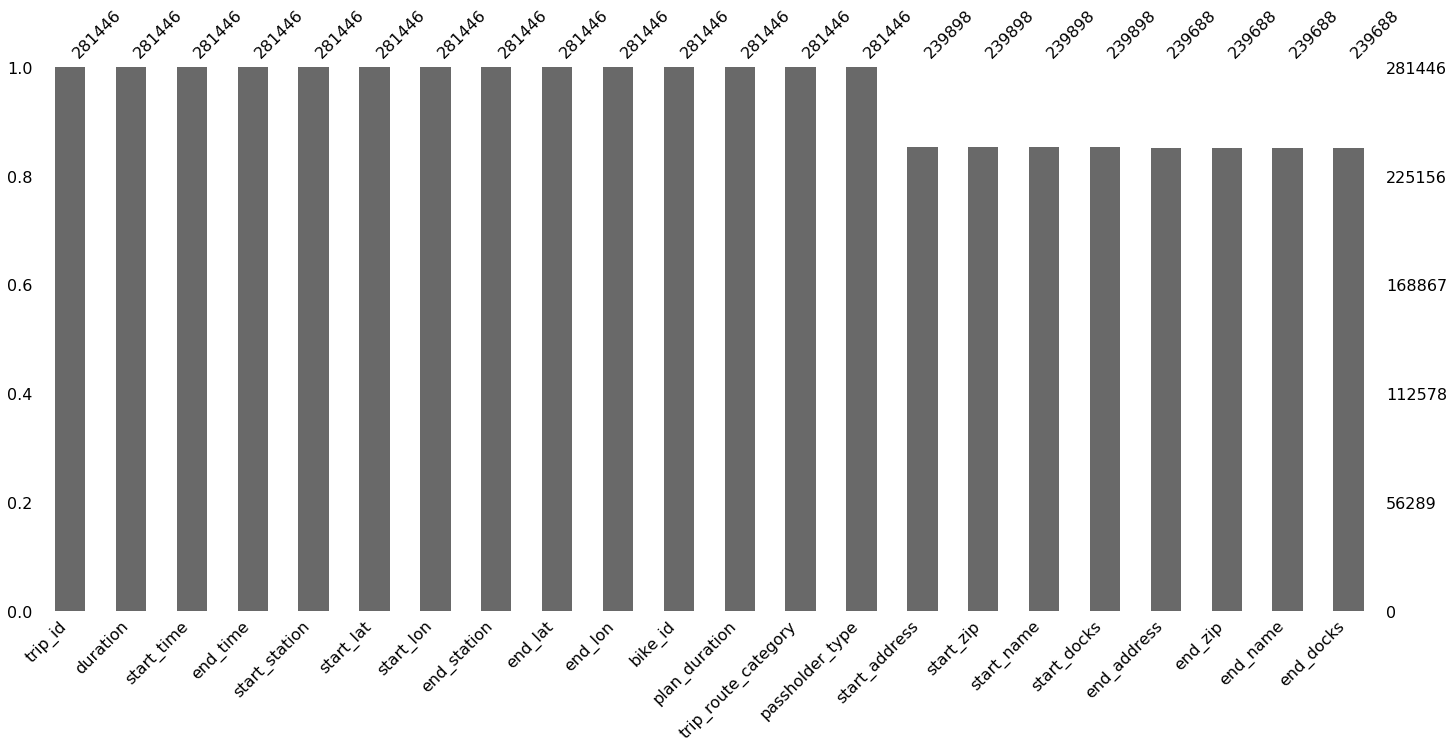

In [438]:
msno.bar(rides_df)

In [392]:
test = pd.merge(rides_df, start_manual_add, how = 'left', on = 'start_station')
msno.bar(test)

KeyError: 'start_station'

In [51]:
print('Dates range from: ', rides_df['start_time'].min(), ' to ', rides_df['start_time'].max())

Dates range from:  2017-07-01 00:09:00  to  2018-06-30 23:52:00


In [50]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_address,start_zip,start_name,start_docks,end_address,end_zip,end_name,end_docks
0,33404951,36,2017-07-01 00:09:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0
1,33404950,13,2017-07-01 00:10:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0
2,33404947,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0
3,33404948,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0
4,33404949,12,2017-07-01 00:11:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0


### Potential EDA:
1. Planning inventory around locations and time
    1. Most common start, end station pairings
    2. Most common time periods
    3. Different heatmaps for different time periods
    4. Start/end station correlation with available docks at location
2. Pricing strategies for different passes
    1. Usage rates across different passes
        1. By duration
        2. By number of trips
        3. Total duration X trips
    2. Geographical gropuing of where most passes originate/end from
    3. Cohort analysis of different groups
    4. How many rides were past the free 30 minute mark?
3. Unit pricing strategies, what if we brought it back? Charging all > 
    1. Based on current pricing strategy, what would total revenue be on a per mile basis
    2. Comparison with Bird/Jump bike pricing
    3. Cohort analysis of different groups
    4. Optimization function for 2 and 3

Pricing strategies can be used to build predictor model for rides, duration, and total revenue

### Feature engineering
1. Hours
2. Free ride with pass? (>30 in time or not)
3. Active or none active bikes (whether they've been used in the past month)

### Current pricing

Day Pass 
$5/day
All rides 30 minutes or less are free
$1.75 per 30 minutes thereafter
 

Sign Up
Monthly Pass
$17/month
All rides 30 minutes or less are free
$1.75 per 30 minutes thereafter
 

Sign Up
Annual Pass
$150/year
Equivalent to $12.50/month
All rides 30 minutes or less are free
$1.75 per 30 minutes thereafter

### Previous pricing

Walk-up
$3.50/30 minutes
All trips 30 minutes or less are $3.50
$3.50 per 30 minutes thereafter
 

Find a Station
One Day Pass
$7/day
All trips 30 minutes or less are free
$1.75 per 30 minutes thereafter


Buy a Pass
Monthly Pass
$20/month
All trips 30 minutes or less are free
$1.75 per 30 minutes thereafter

### Common start end station pairings

In [124]:
from collections import Counter

In [136]:
top10_pairs = Counter(station_pairings).most_common(10)
top10_pairs

[((4214, 4214), 5037),
 ((4210, 4210), 3696),
 ((4214, 4215), 3198),
 ((4210, 4215), 2171),
 ((4153, 4153), 1917),
 ((4215, 4215), 1865),
 ((3030, 3014), 1746),
 ((3014, 3030), 1685),
 ((4214, 4210), 1593),
 ((4210, 4214), 1472)]

In [140]:
def get_pair_address(tup):
    start_add = rides_df['start_address'][rides_df['start_station'] == tup[0][0]].iloc[0]
    end_add = rides_df['end_address'][rides_df['end_station'] == tup[0][1]].iloc[0]
    return(start_add, end_add)

top10_pairs_address = []
for pair in top10_pairs:
    top10_pairs_address.append(get_pair_address(pair))
top10_pairs_address

[('Ocean Front Walk @ Navy St', 'Ocean Front Walk @ Navy St'),
 ('2100 Ocean Front Walk', '2100 Ocean Front Walk'),
 ('Ocean Front Walk @ Navy St', '1621 4th St'),
 ('2100 Ocean Front Walk', '1621 4th St'),
 (nan, nan),
 ('1621 4th St', '1621 4th St'),
 ('120 S Main Street', '834 N Alameda St'),
 ('834 N Alameda St', '120 S Main Street'),
 ('Ocean Front Walk @ Navy St', '2100 Ocean Front Walk'),
 ('2100 Ocean Front Walk', 'Ocean Front Walk @ Navy St')]

In [133]:
top10_pairs

[((4214, 4214), 5037),
 ((4210, 4210), 3696),
 ((4214, 4215), 3198),
 ((4210, 4215), 2171),
 ((4153, 4153), 1917),
 ((4215, 4215), 1865),
 ((3030, 3014), 1746),
 ((3014, 3030), 1685),
 ((4214, 4210), 1593),
 ((4210, 4214), 1472)]

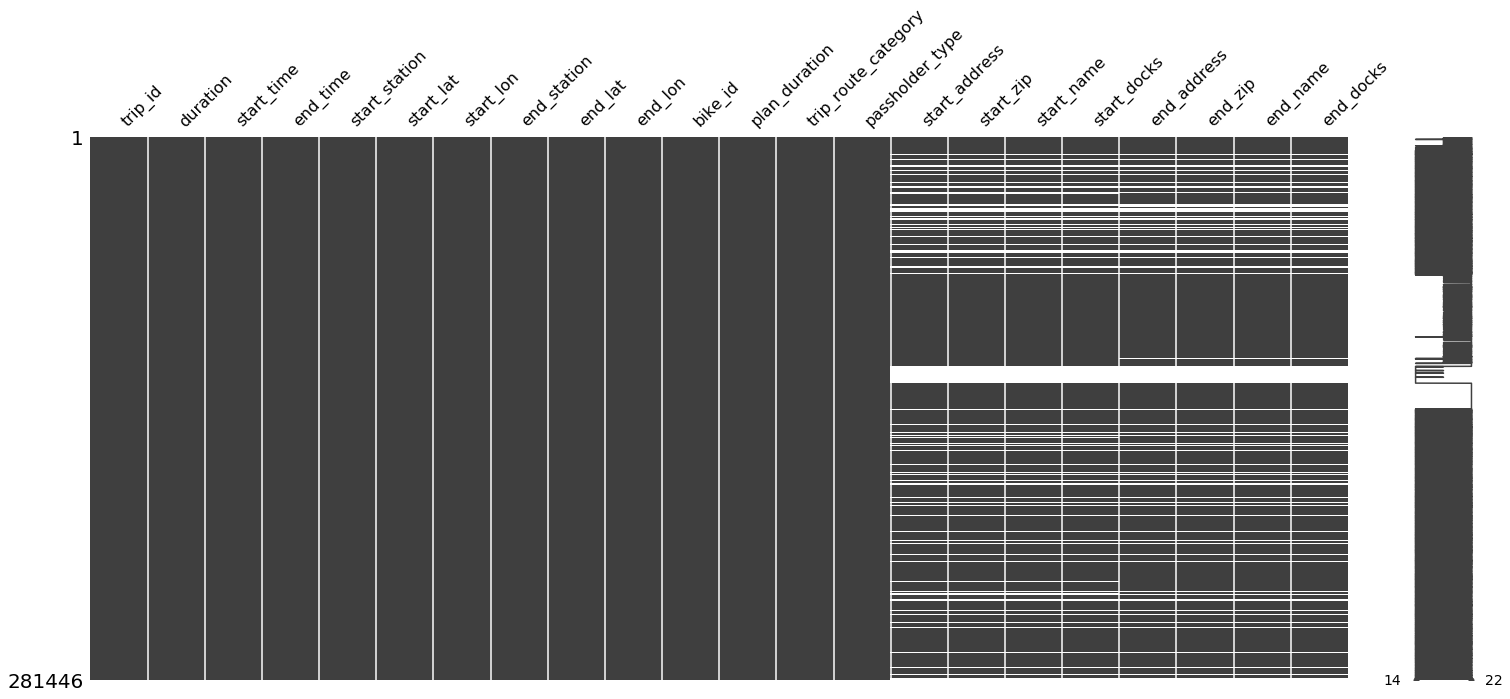

In [142]:
msno.matrix(rides_df)

In [143]:
rides_df[rides_df['start_station'] == 4153]

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_address,start_zip,start_name,start_docks,end_address,end_zip,end_name,end_docks
7162,34974378,20,2017-07-14 12:35:00,2017-07-14 12:55:00,4153,34.156181,-118.166687,4153,34.156181,-118.166687,12135,30,Round Trip,Monthly Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7163,34974380,20,2017-07-14 12:35:00,2017-07-14 12:55:00,4153,34.156181,-118.166687,4153,34.156181,-118.166687,12309,30,Round Trip,Monthly Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7181,34979819,22,2017-07-14 12:56:00,2017-07-14 13:18:00,4153,34.156181,-118.166687,4154,34.156120,-118.151192,12126,30,One Way,Monthly Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7182,34979820,21,2017-07-14 12:56:00,2017-07-14 13:17:00,4153,34.156181,-118.166687,4154,34.156120,-118.151192,12135,30,One Way,Monthly Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7208,34979785,10,2017-07-14 13:23:00,2017-07-14 13:33:00,4153,34.156181,-118.166687,4153,34.156181,-118.166687,12346,30,Round Trip,Monthly Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7891,35116213,57,2017-07-15 12:49:00,2017-07-15 13:46:00,4153,34.156181,-118.166687,4153,34.156181,-118.166687,12344,30,Round Trip,Monthly Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7892,35116212,55,2017-07-15 12:51:00,2017-07-15 13:46:00,4153,34.156181,-118.166687,4153,34.156181,-118.166687,12163,30,Round Trip,Monthly Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8073,35139957,49,2017-07-15 17:10:00,2017-07-15 17:59:00,4153,34.156181,-118.166687,4153,34.156181,-118.166687,12167,0,Round Trip,Walk-up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8076,35139952,20,2017-07-15 17:12:00,2017-07-15 17:32:00,4153,34.156181,-118.166687,4160,34.133011,-118.148560,6044,30,One Way,Monthly Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8190,35158354,21,2017-07-15 19:53:00,2017-07-15 20:14:00,4153,34.156181,-118.166687,4162,34.147499,-118.148010,12344,30,One Way,Monthly Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Common time periods

### Heatmaps for different time periods

### Start/end station correlation with available docks

### Active businesses

https://data.lacity.org/A-Prosperous-City/Listing-of-Active-Businesses/6rrh-rzua

In [20]:
# reading in csv file of active businesses, could be outside of LA
business_df = pd.read_csv('../data/external/active_businesses.csv')

In [21]:
business_df.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION
0,0000000115-0001-3,VINCENZO LABELLA,NaN,521 SWARTHMORE AVENUE,PACIFIC PALISADES,90272-4350,521 SWARTHMORE 90272-4350,521 SWARTHMORE AVENUE,PACIFIC PALISADES,90272-4350,561500.0,Travel arrangement & reservation services,11,01/01/1990,NaN,NaN
1,0000000150-0001-5,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,2015 W TEMPLE STREET,LOS ANGELES,90026-4913,2015 TEMPLE 90026-4913,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",13,01/01/1991,NaN,NaN
2,0000000156-0001-2,SPRINGBOARD NON-PROFIT CONSUMER CREDIT MANAGEMENT,MONEY MANAGEMENT INTERNATIONAL,1605 W OLYMPIC BLVD #9023,LOS ANGELES,90015-3828,1605 OLYMPIC 90015-3828,NaN,NaN,NaN,523900.0,Other financial investment activities (includi...,1,02/01/1999,NaN,NaN
3,0000000225-0001-5,STRATEGIC CONCEPTS IN ORGANIZING AND POLICY ED...,NaN,1715 W FLORENCE AVENUE,LOS ANGELES,90047-2220,1715 FLORENCE 90047-2220,NaN,NaN,NaN,611000.0,"Educational services (including schools, colle...",8,06/03/1997,NaN,NaN
4,0000000247-0001-1,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,3806 W PICO BLVD,LOS ANGELES,90019-4304,3806 PICO 90019-4304,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",10,01/01/1991,NaN,NaN


In [22]:
# check to see how many different cities there are in the column
business_df['CITY'].unique()

array(['PACIFIC PALISADES', 'LOS ANGELES', 'GRANADA HILLS', ..., 'ARDEN',
       'LOS BANOS', 'DEBARY'], dtype=object)

As the focus of the ride sharing data is in the LA metro area, we will only focus on the data in that area and only include data with the city variable matching 'Los Angeles'.

By doing so, we see that around 50% of the initial dataset remains.

In [23]:
business_df = business_df[business_df['CITY'] == 'LOS ANGELES']
business_df.shape

(250920, 16)

A look at the dataframe also reveals many NaN values. Using msno, we see that there are multiple columns like 'DBA NAME' and 'MAILING CITY' that are almost completely empty.

There are also many variables that are not as relevant in our analysis. Our main purpose of obtaining the dataset of active businesses is to visualize their locations. We will thus select only the relevant columns and rename them accordingly.

In [24]:
business_df.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION
1,0000000150-0001-5,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,2015 W TEMPLE STREET,LOS ANGELES,90026-4913,2015 TEMPLE 90026-4913,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",13,01/01/1991,NaN,NaN
2,0000000156-0001-2,SPRINGBOARD NON-PROFIT CONSUMER CREDIT MANAGEMENT,MONEY MANAGEMENT INTERNATIONAL,1605 W OLYMPIC BLVD #9023,LOS ANGELES,90015-3828,1605 OLYMPIC 90015-3828,NaN,NaN,NaN,523900.0,Other financial investment activities (includi...,1,02/01/1999,NaN,NaN
3,0000000225-0001-5,STRATEGIC CONCEPTS IN ORGANIZING AND POLICY ED...,NaN,1715 W FLORENCE AVENUE,LOS ANGELES,90047-2220,1715 FLORENCE 90047-2220,NaN,NaN,NaN,611000.0,"Educational services (including schools, colle...",8,06/03/1997,NaN,NaN
4,0000000247-0001-1,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,3806 W PICO BLVD,LOS ANGELES,90019-4304,3806 PICO 90019-4304,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",10,01/01/1991,NaN,NaN
5,0000000267-0001-9,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,3115 VENICE BLVD,LOS ANGELES,90019-6238,3115 VENICE 90019-6238,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",10,01/01/1991,NaN,NaN


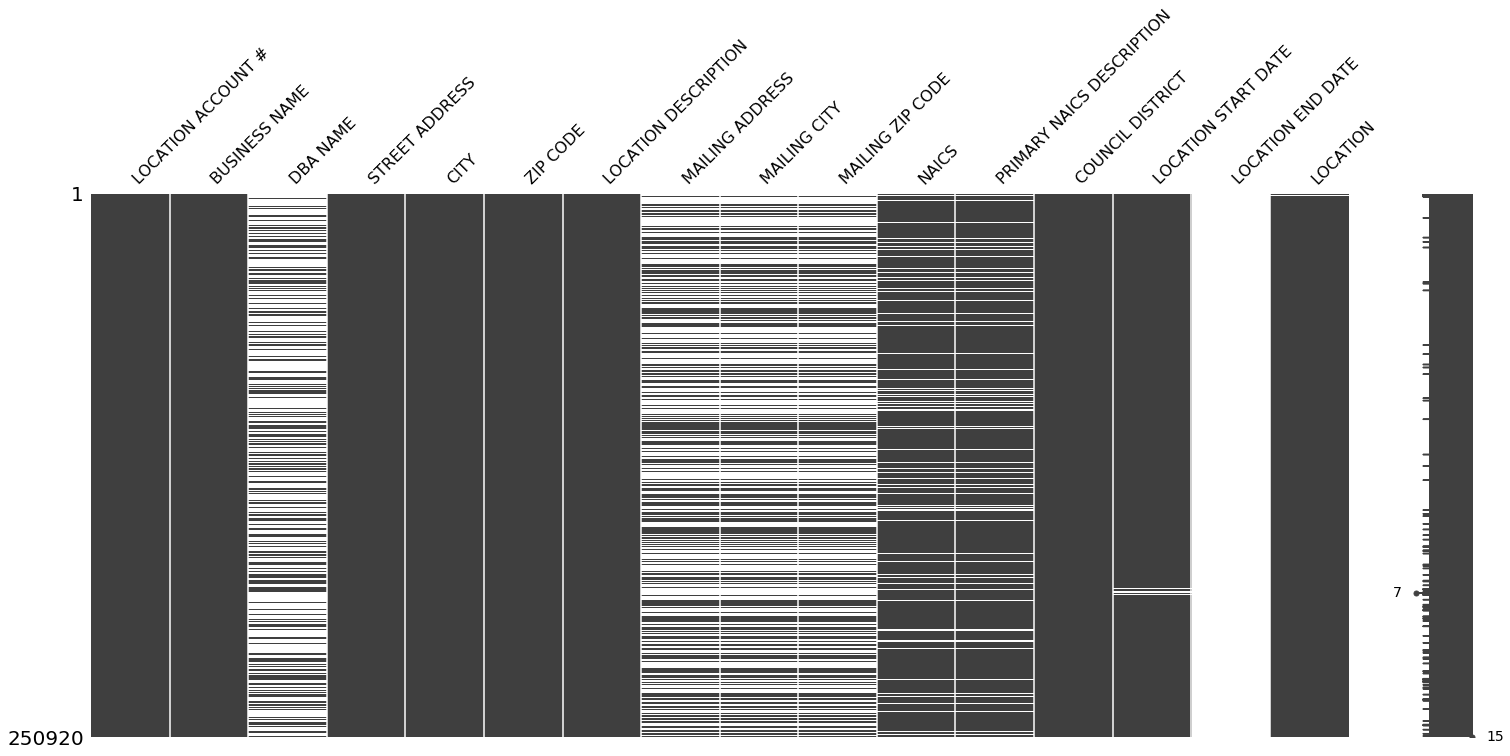

In [25]:
msno.matrix(business_df)

In [26]:
business_df = business_df[['BUSINESS NAME', 'STREET ADDRESS', 'ZIP CODE', 'LOCATION START DATE', 'LOCATION']].rename(columns = {'BUSINESS NAME':'business_name', 'STREET ADDRESS':'street_address', 'ZIP CODE':'zip_code', 'LOCATION START DATE':'start_date', 'LOCATION':'coordinates'})
business_df.head()

,business_name,street_address,zip_code,start_date,coordinates
1,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,2015 W TEMPLE STREET,90026-4913,01/01/1991,NaN
2,SPRINGBOARD NON-PROFIT CONSUMER CREDIT MANAGEMENT,1605 W OLYMPIC BLVD #9023,90015-3828,02/01/1999,NaN
3,STRATEGIC CONCEPTS IN ORGANIZING AND POLICY ED...,1715 W FLORENCE AVENUE,90047-2220,06/03/1997,NaN
4,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,3806 W PICO BLVD,90019-4304,01/01/1991,NaN
5,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,3115 VENICE BLVD,90019-6238,01/01/1991,NaN


There seems to be quite a few businesses that do not have coordinates. A quick filter reveals 1583 of them. These seem to be businesses that were incorporate very early on before 2000. As this is a very small portion of the dataset, we can safely drop them.

Another anomaly that popped up were coordinates of (0,0). As this is a location in the middle of the ocean, these coordinates are unlikely to mean anything and will be dropped.

In [27]:
# counting the number of businesses without coordinates
business_df['coordinates'].isna().sum()

1583

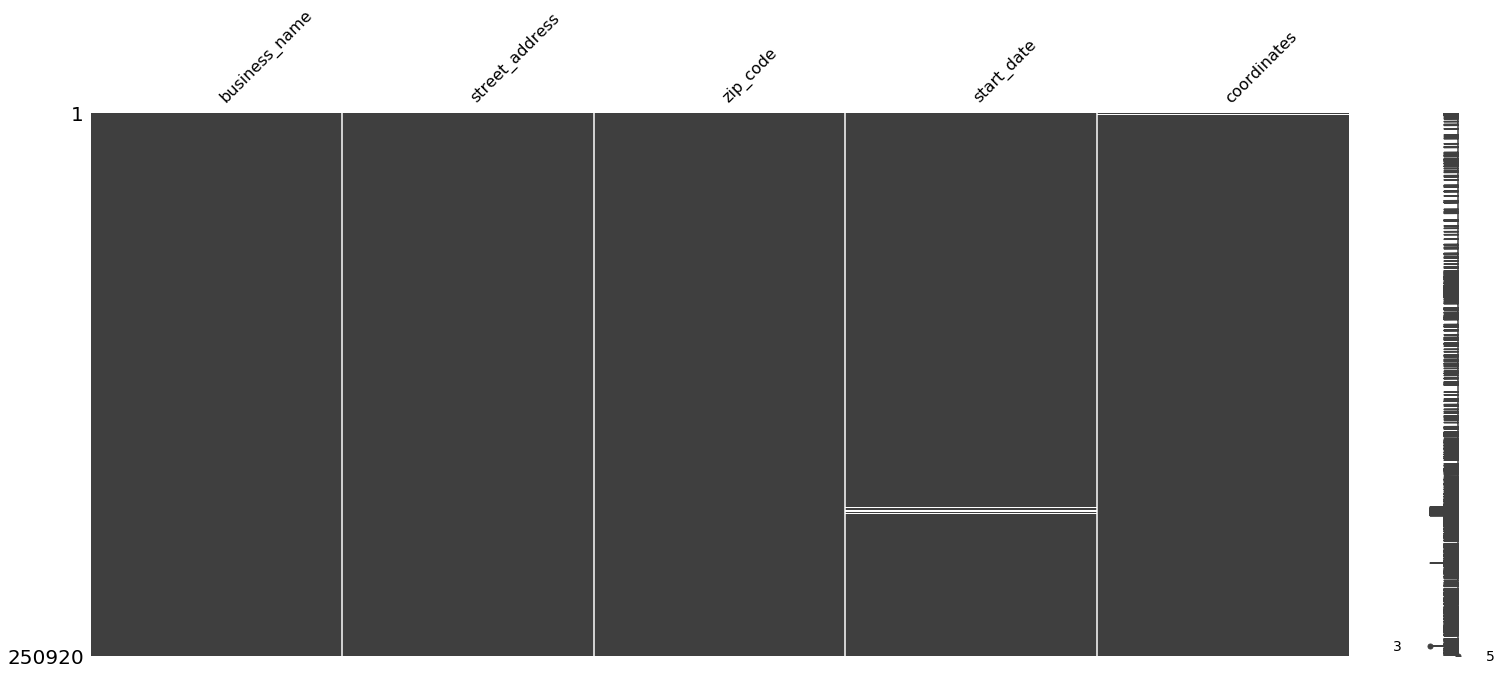

In [28]:
msno.matrix(business_df)

In [29]:
# dropping na coordinate values
business_df = business_df.dropna()

In [30]:
# dropping coordinates of (0,0) and resetting the index to start from 0
business_df = business_df[business_df['coordinates'] != '(0, 0)'].reset_index()
business_df.shape

(245437, 6)

In [31]:
business_df.loc[1]['coordinates']

'(34.044, -118.292)'

As the coordinate variable is a string with the latitude and longitude values, we shall use regex functions to pull the latitude and longtitude variables out and convert them to a float type. 

Here we use positive lookbehind and positive lookahead to target the exact part of the string that we need because each latitude and longitude pair has the same structure.

In [32]:
# regex to extract latitude
def get_lat(coords):
    lat = re.compile('(?<=\().+(?=\,)')
    return float(lat.search(coords).group())

# regex to extract longitude
def get_long(coords):
    long = re.compile('(?<=\, ).+(?=\))')
    return float(long.search(coords).group())

print("latitude: " + str(get_lat(business_df.loc[1]['coordinates'])) + " longitude: " + str(get_long(business_df.loc[1]['coordinates'])))

latitude: 34.044 longitude: -118.292


In [33]:
# apply get_lat and get_long functions to create new columns representing latitude and longitude for each business
business_df['latitude'] = business_df['coordinates'].apply(get_lat)
business_df['longitude'] = business_df['coordinates'].apply(get_long)
business_df = business_df.drop(['coordinates'],axis=1)
business_df.head()

,index,business_name,street_address,zip_code,start_date,latitude,longitude
0,10,CORALIE WHITCOMB,2669 MEDLOW AVENUE,90065-4616,06/10/2017,34.1269,-118.2247
1,56,RMJC INSURANCE SERVICES INC,1601 S VERMONT AVENUE SUITE #103,90006-4541,03/07/2017,34.0440,-118.2920
2,59,DANIELLE HALFERTY,2527 CANYON DRIVE,90068-2415,09/18/2017,34.1164,-118.3165
3,61,PETER J HARRIS,4153 MARLTON AVENUE #3,90008-3525,01/01/1998,34.0101,-118.3416
4,62,CARNIVAL LUXE LLC,234 S FIGUEROA STREET APARTMENT #1235,90012-2525,12/06/2016,34.0559,-118.2536


### Traffic collisions 2010-2018

https://www.kaggle.com/cityofLA/los-angeles-traffic-collision-data/version/7#traffic-collision-data-from-2010-to-present.csv

In [34]:
traffic_df = pd.read_csv('../data/external/traffic_collisions_2010_2018.csv')

In [35]:
traffic_df.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Location
0,100119684,11042010-01-01T00:00:00,2010-11-04T00:00:00,1345,1,Central,159,997,TRAFFIC COLLISION,NaN,20.0,F,H,101.0,STREET,7TH ST,LAWRENCE ST,"{'needs_recoding': False, 'longitude': '-118.2..."
1,101221255,8102010-01-01T00:00:00,2010-08-10T00:00:00,1900,12,77th Street,1211,997,TRAFFIC COLLISION,NaN,31.0,F,B,101.0,STREET,54TH ST,3RD AV,"{'needs_recoding': False, 'longitude': '-118.3..."
2,101414426,6112010-01-01T00:00:00,2010-06-09T00:00:00,1925,14,Pacific,1488,997,TRAFFIC COLLISION,NaN,40.0,F,B,101.0,STREET,MANCHESTER BL,BELLANCA AV,"{'needs_recoding': False, 'longitude': '-118.3..."
3,102109168,4062010-01-01T00:00:00,2010-04-06T00:00:00,1445,21,Topanga,2197,997,TRAFFIC COLLISION,1501,51.0,M,O,101.0,STREET,ROSITA AV,CORBIN AV,"{'needs_recoding': False, 'longitude': '-118.5..."
4,100322445,9222010-01-01T00:00:00,2010-05-23T00:00:00,1805,3,Southwest,397,997,TRAFFIC COLLISION,NaN,32.0,F,H,101.0,STREET,43RD PL,WALTON AV,"{'needs_recoding': False, 'longitude': '-118.2..."


In [36]:
traffic_df['Victim Descent'].unique()

array(['H', 'B', 'O', 'W', 'X', 'A', nan, 'K', 'C', 'F', 'U', 'J', 'P',
       'V', 'Z', 'I', 'G', 'S', 'D', 'L', '-'], dtype=object)

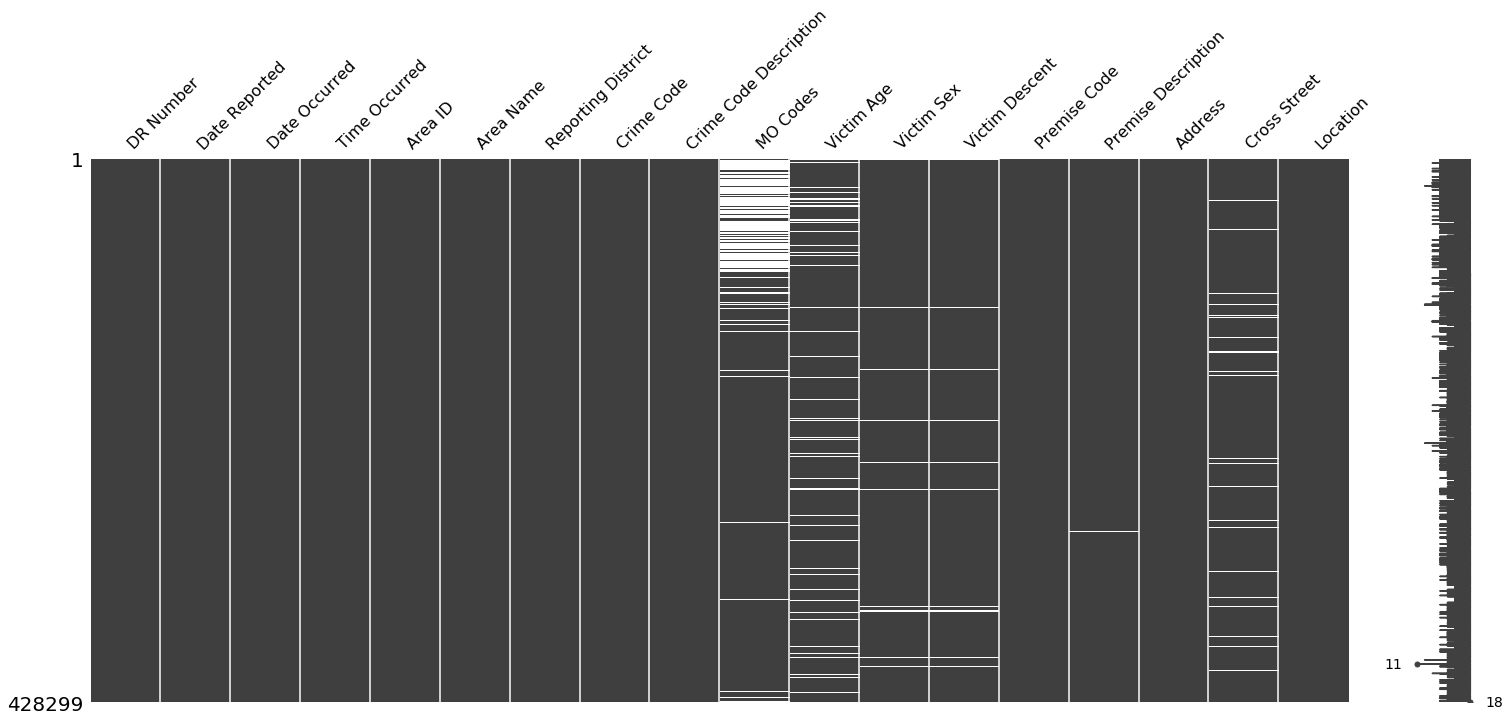

In [37]:
msno.matrix(traffic_df)

In [38]:
traffic_df = traffic_df[['Date Occurred', 'Time Occurred', 'Area Name', 'Victim Age', 
                         'Victim Sex', 'Victim Descent', 'Address', 'Cross Street', 'Location']]
traffic_df = traffic_df.rename(columns = {'Date Occurred':'date_occured', 
                             'Time Occurred':'time_occured', 'Area Name':'area_name', 'Victim Age':'victim_age', 
                             'Victim Sex':'victim_sex', 'Victim Descent':'victim_descent', 'Address':'address', 
                             'Cross Street':'cross_street', 'Location':'location'})
traffic_df.head()

,date_occured,time_occured,area_name,victim_age,victim_sex,victim_descent,address,cross_street,location
0,2010-11-04T00:00:00,1345,Central,20.0,F,H,7TH ST,LAWRENCE ST,"{'needs_recoding': False, 'longitude': '-118.2..."
1,2010-08-10T00:00:00,1900,77th Street,31.0,F,B,54TH ST,3RD AV,"{'needs_recoding': False, 'longitude': '-118.3..."
2,2010-06-09T00:00:00,1925,Pacific,40.0,F,B,MANCHESTER BL,BELLANCA AV,"{'needs_recoding': False, 'longitude': '-118.3..."
3,2010-04-06T00:00:00,1445,Topanga,51.0,M,O,ROSITA AV,CORBIN AV,"{'needs_recoding': False, 'longitude': '-118.5..."
4,2010-05-23T00:00:00,1805,Southwest,32.0,F,H,43RD PL,WALTON AV,"{'needs_recoding': False, 'longitude': '-118.2..."


In [39]:
traffic_df.dtypes

date_occured       object
time_occured        int64
area_name          object
victim_age        float64
victim_sex         object
victim_descent     object
address            object
cross_street       object
location           object
dtype: object

In [40]:
traffic_df['date_occured'] = pd.to_datetime(traffic_df['date_occured'])

In [41]:
traffic_df.loc[1]['location']

'{\'needs_recoding\': False, \'longitude\': \'-118.3203\', \'human_address\': \'{"address":"","city":"","state":"","zip":""}\', \'latitude\': \'33.9932\'}'

In [42]:
def get_lat(coords):
    lat = re.compile('(?<=latitude\': \').+(?=\'})')
    return(float(lat.search(coords).group()))

def get_long(coords):
    long = re.compile('(?<=longitude\': \').+(?=\', \'h)')
    return float(long.search(coords).group())

traffic_df['latitude'] = traffic_df['location'].apply(get_lat)
traffic_df['longitude'] = traffic_df['location'].apply(get_long)
traffic_df = traffic_df.drop('location',1)
traffic_df.head()

,date_occured,time_occured,area_name,victim_age,victim_sex,victim_descent,address,cross_street,latitude,longitude
0,2010-11-04,1345,Central,20.0,F,H,7TH ST,LAWRENCE ST,34.0348,-118.2362
1,2010-08-10,1900,77th Street,31.0,F,B,54TH ST,3RD AV,33.9932,-118.3203
2,2010-06-09,1925,Pacific,40.0,F,B,MANCHESTER BL,BELLANCA AV,33.9599,-118.3805
3,2010-04-06,1445,Topanga,51.0,M,O,ROSITA AV,CORBIN AV,34.1585,-118.5633
4,2010-05-23,1805,Southwest,32.0,F,H,43RD PL,WALTON AV,34.0055,-118.2948


In [43]:
traffic_df.dtypes

date_occured      datetime64[ns]
time_occured               int64
area_name                 object
victim_age               float64
victim_sex                object
victim_descent            object
address                   object
cross_street              object
latitude                 float64
longitude                float64
dtype: object